In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import pandas as pd
import seaborn as sns

In [2]:
gray_images = []

for i in range(12):
    if i < 9:
        prefix = '0'
    else:
        prefix = ''
    gray_images.append(cv.imread(f'{prefix}{i + 1}.tif', cv.IMREAD_GRAYSCALE))

In [3]:
def get_harris_dst(images):
    dsts = []
    kp_count = 0
    for img in images:
        dst = cv.cornerHarris(img, 2, 3, 0.04)
        kp_count += len(dst)
        dsts.append(dst)
    return dsts, kp_count

def get_sift_dst(images):
    sift = cv.SIFT_create()
    dsts = []
    kp_count = 0
    for img in images:
        _, dst = sift.detectAndCompute(img, None)
        kp_count += len(dst)
        dsts.append(dst)
    return dsts, kp_count

def get_orb_dst(images):
    orb = cv.ORB_create()
    dsts = []
    kp_count = 0
    for img in images:
        _, dst = orb.detectAndCompute(img, None)
        kp_count += len(dst)
        dsts.append(dst)
    return dsts, kp_count

In [4]:
import time
start_time = time.time()
harris_dsts, kp_count = get_harris_dst(gray_images)
time_consumed = time.time() - start_time    
print(f"Harris time consumed for one key point: {time_consumed / kp_count}") 

start_time = time.time()
sift_dsts, kp_count = get_sift_dst(gray_images)
time_consumed = time.time() - start_time    
print(f"SIFT time consumed for one key point: {time_consumed / kp_count}") 

start_time = time.time()
orb_dsts, kp_count = get_orb_dst(gray_images)
time_consumed = time.time() - start_time    
print(f"ORB time consumed for one key point: {time_consumed / kp_count}") 

Harris time consumed for one key point: 3.2537513309054904e-06
SIFT time consumed for one key point: 2.683161847998093e-05
ORB time consumed for one key point: 1.0536407693846977e-05


In [5]:
from scipy.spatial import distance

def calc_matches(dst1, dst2, number_of_occurences, norm=distance.euclidean):
    closest1 = {k: None for k in range(len(dst1))}
    closest2 = {k: None for k in range(len(dst2))}
        
    for i, d1 in enumerate(dst1):
        for j, d2 in enumerate(dst2): 
            dist = norm(d1, d2)
            if closest1[i] is None or closest1[i][1] > dist:
                closest1[i] = (j, dist)

            if closest2[j] is None or closest2[j][1] > dist:
                closest2[j] = (i, dist)
    for k, v in closest1.items():
        other_dst_index = v[0]
        if closest2[other_dst_index] is not None and closest2[other_dst_index][0] == k:
            number_of_occurences[k] += 1
    return number_of_occurences

In [15]:
# code using cv.BFMatcher
def calc_repeatability(descriptors, norm=cv.NORM_L2):   
    bf = cv.BFMatcher(norm, crossCheck=True)
    repeatabilities = []
    for i, dst1 in enumerate(descriptors):
        number_of_occurences = {k: 0 for k in range(len(dst1))}
        for j, dst2 in enumerate(descriptors):
            if i == j:
                continue
            matches = bf.match(dst1,dst2)
            for m in matches:
                number_of_occurences[m.queryIdx] += 1
        repeatability = (np.array(list(number_of_occurences.values())) / (len(descriptors) - 1)).mean()
        repeatabilities.append(repeatability)
    return repeatabilities


# same code, but with my realization of descriptors matching
# def calc_repeatability(descriptors, norm=distance.euclidean):   
#     repeatabilities = []
#     for i, dst1 in enumerate(descriptors):
#         number_of_occurences = {k: 0 for k in range(len(dst1))}
#         for j, dst2 in enumerate(descriptors):
#             if i == j:
#                 continue
#             number_of_occurences = calc_matches(dst1, dst2, number_of_occurences, norm)
#         repeatability = (np.array(list(number_of_occurences.values())) / (len(descriptors) - 1)).mean()
#         repeatabilities.append(repeatability)
#     return repeatabilities

In [7]:
%%time
harris_repeatabilities = calc_repeatability(harris_dsts, norm=distance.euclidean)

# %%time
# harris_repeatabilities = calc_repeatability(harris_dsts, norm=cv.NORM_L2)

CPU times: user 38.8 s, sys: 105 ms, total: 38.9 s
Wall time: 38.9 s


In [8]:
%%time
sift_repeatabilities = calc_repeatability(sift_dsts, norm=distance.euclidean)

# %%time
# sift_repeatabilities = calc_repeatability(sift_dsts, norm=cv.NORM_L2)

CPU times: user 4min 6s, sys: 297 ms, total: 4min 7s
Wall time: 4min 7s


In [9]:
%%time
orb_repeatabilities = calc_repeatability(orb_dsts, norm=distance.hamming)

# %%time
# orb_repeatabilities = calc_repeatability(orb_dsts, norm=cv.NORM_HAMMING)

CPU times: user 3min 47s, sys: 464 ms, total: 3min 48s
Wall time: 3min 48s


In [19]:
harris_df = pd.DataFrame(data = {'frame_number': np.arange(12) + 1, 'repeatability' : harris_repeatabilities})
sift_df = pd.DataFrame(data = {'frame_number': np.arange(12) + 1, 'repeatability' : sift_repeatabilities})
orb_df = pd.DataFrame(data = {'frame_number': np.arange(12) + 1, 'repeatability' : orb_repeatabilities})

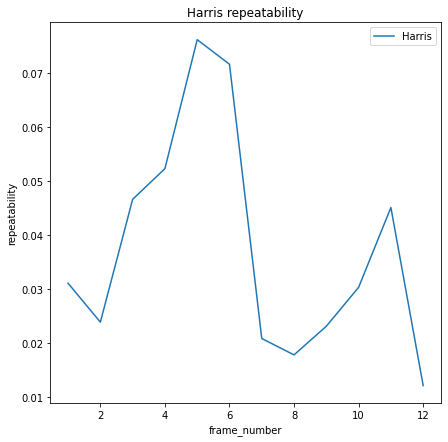

In [20]:
plt.figure(figsize=(7, 7))
plt.title('Harris repeatability')
sns.lineplot(data = harris_df, x='frame_number',y='repeatability', label='Harris')
plt.show()

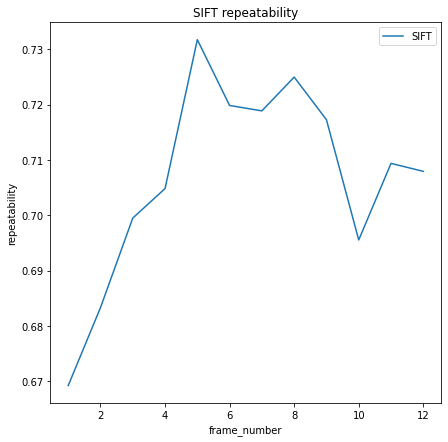

In [21]:
plt.figure(figsize=(7, 7))
plt.title('SIFT repeatability')
sns.lineplot(data = sift_df, x='frame_number',y='repeatability', label='SIFT')
plt.show()

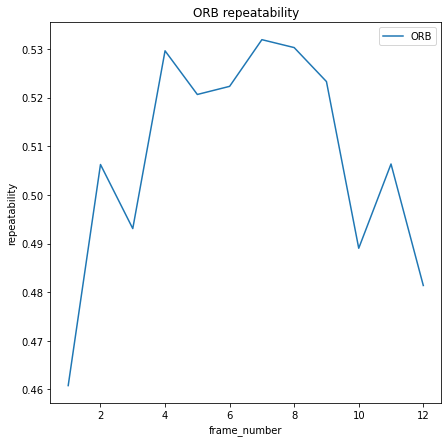

In [22]:
plt.figure(figsize=(7, 7))
plt.title('ORB repeatability')
sns.lineplot(data = orb_df, x='frame_number',y='repeatability', label='ORB')
plt.show()

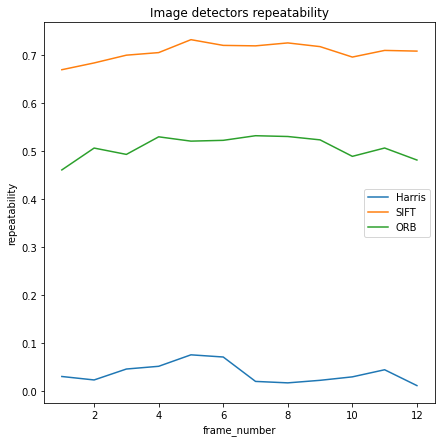

In [23]:
plt.figure(figsize=(7, 7))
plt.title('Image detectors repeatability')
sns.lineplot(data = harris_df, x='frame_number',y='repeatability', label='Harris')
sns.lineplot(data = sift_df, x='frame_number',y='repeatability', label='SIFT')
sns.lineplot(data = orb_df, x='frame_number',y='repeatability', label='ORB')
plt.show()

__Вывод__: SIFT имеет самое долгое время работы в пересчёте на одну точку, но показывает самый высокий уровень воспроизводимости. Воспроизводимость Harris очень низкая